## Model inference


A system for face recognition typically conststs of 3 stages:
- face detection
- face alignment
- face recognition

Let's discuss them in detail:

**Face detection**

When the camera is hanged on the wall it records a video and splits the video into single images, like this:

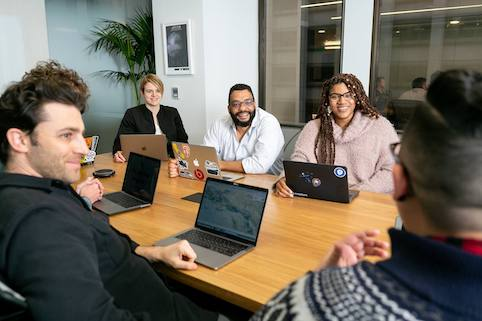

To be able to recognize all the faces on the photo you need first to detect all the faces that are present on the photo, like this:

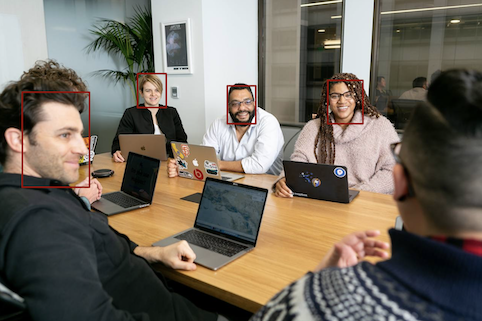

That is the first part — detection. You could use any neural network that can detect humans for this.

**Face alignment**

The second stage is to align all the faces found. The alignment procedure here should be the same as used to align training images.

So we'll get an image of a guy on a photo aligned like this:

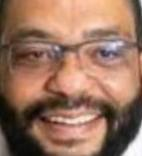

**Face recognition**

On the third stage we use the neural network that we trained to recognize a face.

## Part 1: Building a neural network for faces classification based on CE loss.

### Dataset

- celebA_imgs — folder with aligned images
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [ ]:
# dataset
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.ru/d/S8f03spLIA1wrw) -o celebA_train.zip
! unzip -qq celebA_train.zip
# facenet
! git clone https://github.com/timesler/facenet-pytorch.git
! mv facenet-pytorch/models ./
!pip install facenet-pytorch

import os
import sys
import cv2
import numpy as np
import time
import torchvision
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
import seaborn as sns

from collections import defaultdict
from pathlib import Path
from torch.optim import lr_scheduler
from torch import nn
from tqdm.autonotebook import trange
from tqdm.notebook import tqdm
from facenet_pytorch import  InceptionResnetV1
from torchvision import datasets, models, transforms
from tabulate import tabulate
from PIL import Image
from skimage import io, transform
from torch.utils.data import Dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  162M  100  162M    0     0  7612k      0  0:00:21  0:00:21 --:--:-- 10.1M
Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 1306, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 1306 (delta 25), reused 49 (delta 23), pack-reused 1249
Receiving objects: 100% (1306/1306), 22.89 MiB | 17.64 MiB/s, done.
Resolving deltas: 100% (635/635), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.5 MB/s eta 0:00:00


<ipython-input-1-8a6983f2e923>:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


Visualizing some images:

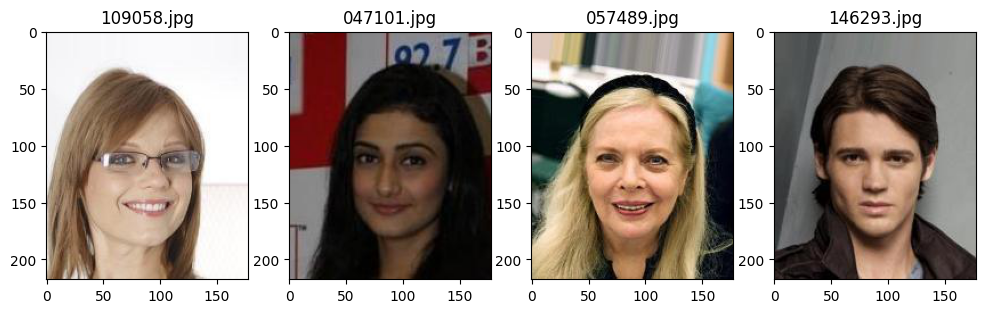

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.is_available()

def show_imgs(images_names):
    imgs = []
    for img in images_names:
      img = Image.open(os.path.join('celebA_train_500/celebA_imgs/', img))
      imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

images_names = os.listdir('./celebA_train_500/celebA_imgs/')[:4]
show_imgs(images_names)

### Train Neural Network

In [ ]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:
        images_paths.append(os.path.join('celebA_train_500/celebA_imgs/', filename))

    return np.array(images_paths)


class celebADataset(Dataset):
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)
        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

        self.transform = transform
        self.aug = aug

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_name)

        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            sample = {
                'image': image,
                'label': label,
            }

        sample['image'] = self.transform(sample['image'])

        return sample

In [ ]:
transform = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.3, 0.3, 0.3)),
])

transform_train = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.3, 0.3, 0.3)),
      transforms.RandomHorizontalFlip()
])

train_data = celebADataset('train', transform_train)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

batch_size = 50
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

dataset_sizes = {
    'train': len(train_data),
    'val': len(val_data)
}

**Workflow**:

*   Training a model on train_data using val_data for validation
*   Using standard CE loss
*   Calculating the loss and accuracy on test set after training

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], "val": []}
    accur = {'train': [], "val": []}
    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for data in tqdm(loader, leave=False, desc=f"{phase} iter:"):
                inputs, labels = data['image'], data['label']

                if use_gpu:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                else:
                    inputs, labels = inputs, labels

                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "val":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + optimizer
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # stats
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            accur[phase].append(epoch_acc)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model
    model.load_state_dict(best_model_wts)
    return model, losses, accur

In [ ]:
model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = 500)

for param in model.parameters():
    param.requires_grad = False

model.last_linear = nn.Sequential(
    nn.Linear(in_features=1792, out_features=2000, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(2000, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
    nn.Linear(in_features=2000, out_features=1500, bias=False),
    nn.ReLU(),
)
model.last_bn = nn.BatchNorm1d(1500, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
model.logits = nn.Linear(in_features=1500, out_features=500, bias=True)

if use_gpu:
  model = model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer_ft = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.5)

In [ ]:
model, losses, accur = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=10)
torch.save(model.state_dict(), 'model_CE.pt')

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

Training complete in 7m 20s
Best val Acc: 0.937167


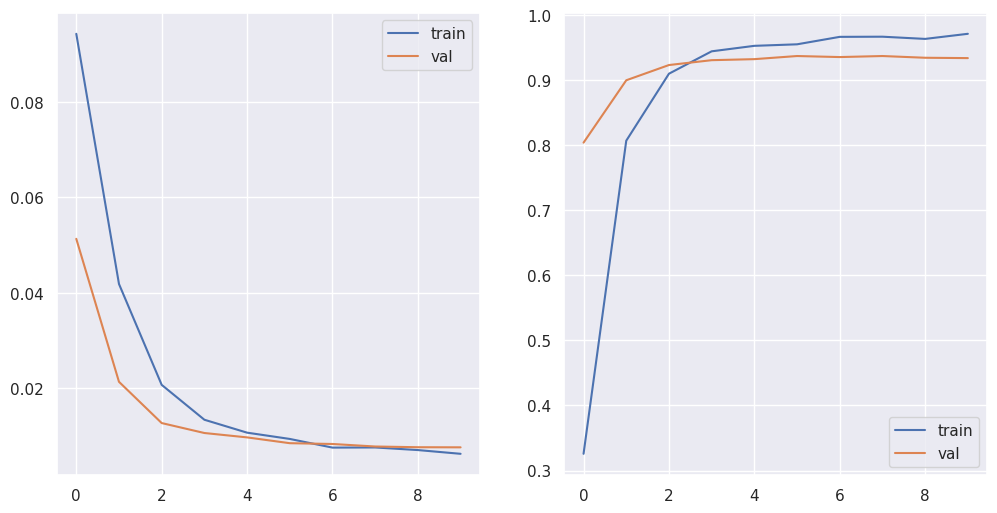

In [ ]:
sns.set(font_scale=1.0)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(losses['train'], label="train")
axs[0].plot(losses['val'], label="val")
axs[0].legend()
axs[1].plot(accur['train'], label="train")
axs[1].plot(accur['val'], label="val")
axs[1].legend()
plt.legend()
plt.show()

**Evaluate**:

In [ ]:
def evaluate(model, dataloader, loss_fn):

    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):

        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)

        with torch.no_grad():
            logits = model(X_batch.to(device))

            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())

            y_pred = torch.argmax(logits, dim=1)

            num_correct += torch.sum(y_pred.cpu() == y_batch)

    accuracy = num_correct / num_elements

    return accuracy, np.mean(losses)

In [ ]:
test_accuracy, test_loss = evaluate(model, test_loader, loss_fn)
print(f'test_accuracy: {test_accuracy}, test_loss: {test_loss}')

test_accuracy: 0.9389553070068359, test_loss: 0.396349138347432


**Cosine similarity calculation**:

In [ ]:
model.load_state_dict(torch.load('/content/model_CE.pt'))
model.classify = False
model.eval()
model = model.to(device)

train_paths = get_paths('train')
test_paths = get_paths('test')
train_loader_1im = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
test_loader_1im = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

In [ ]:
def cosine_similarity(v1, v2):
    norm_v1 = torch.sqrt(torch.sum(v1*v1))
    norm_v2 = torch.sqrt(torch.sum(v2*v2))
    v12 = torch.sum(v1*v2)
    return (v12 / (norm_v1*norm_v2)).item()

def matrix_similarity(T1, T2):
    T1_n, T2_n = T1.norm(dim=1)[:, None], T2.norm(dim=1)[:, None]
    T1_norm = T1 / torch.max(T1_n, 1e-5*torch.ones_like(T1_n))
    T2_norm = T2 / torch.max(T2_n, 1e-5*torch.ones_like(T2_n))
    matrix = torch.mm(T1_norm, T2_norm.transpose(0, 1))
    return matrix.cpu().numpy()

In [ ]:
def plot(train_dict, test_dict, res_cs, min_img=4, dist=False):
  if not dist:
    size = min(min_img, min(len(train_dict), len(test_dict)))
    res_cs = []
    for i in range(size):
        res1 = model(train_dict[i][1]["image"].to(device))
        res2 = model(test_dict[i][1]["image"].to(device))
        res_cs.append(cosine_similarity(res1, res2))


    f, axes= plt.subplots(2, size, figsize=(3*size, 7))
    for i in range(size):
        image = Image.open(train_paths[train_dict[i][0]])
        axes[0][i].imshow(image, cmap='gray')
        image = Image.open(test_paths[test_dict[i][0]])
        axes[1][i].imshow(image, cmap = 'gray')
        axes[1][i].set_title("cosine_sim = " + f"{res_cs[i]:.3f}")

    for i, ax in enumerate(axes.flat):
        if i == 0:
            ax.set(ylabel = 'From train data')
        if i == size:
            ax.set(ylabel = 'From test data')

    plt.show()
  else:
    size = min(len(train_dict), len(test_dict))
    for i in range(size):
        res1 = model(train_dict[i][1]["image"].to(device))
        res2 = model(test_dict[i][1]["image"].to(device))
        res_cs.append(cosine_similarity(res1, res2))
    return res_cs

Example of cosine similarity of images of the same person from train and test set:

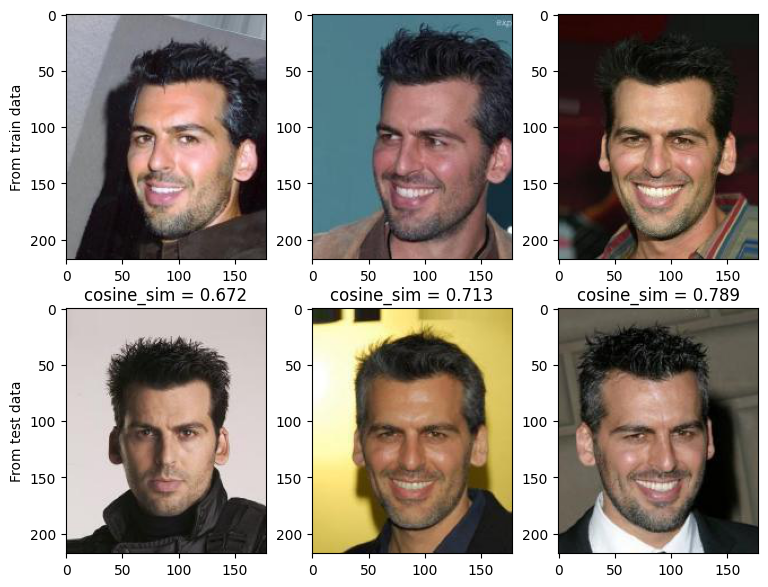

In [ ]:
person = torch.randint(0, 499, (1, 1)).item()
train_dict = []
test_dict = []

for i, train in enumerate(train_loader_1im):
    if person == train['label'].item():
        train_dict.append((i, train))
for i, test in enumerate(test_loader_1im):
    if person == test['label'].item():
        test_dict.append((i, test))
plot(train_dict, test_dict, [])

Example cosine similarity for 1 person from train with any persons from test set:

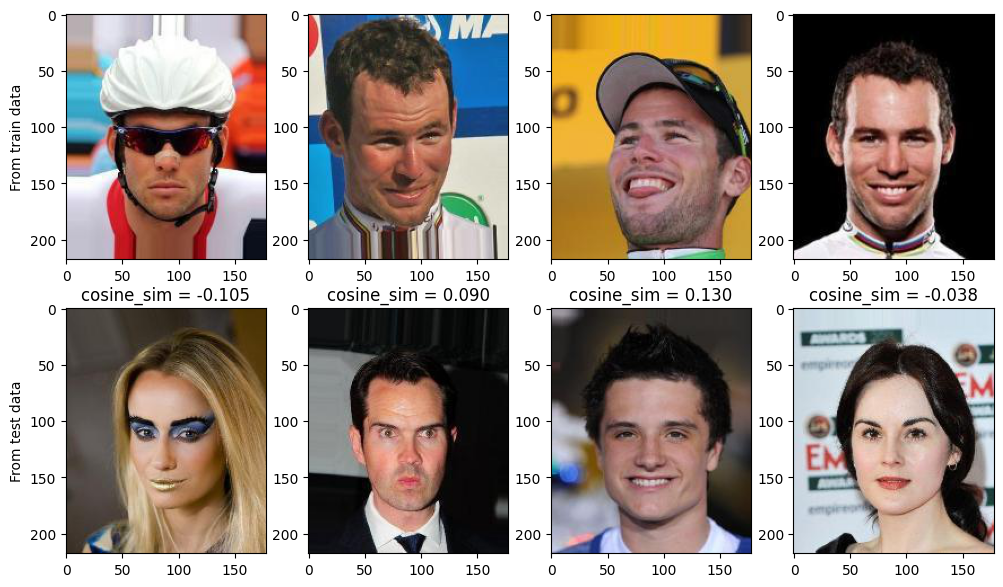

In [ ]:
train_dict = []
test_dict = []
person_1 = torch.randint(249, 499, (1, 1)).item()

for i, train in enumerate(train_loader_1im):
    if person_1 == train['label'].item():
        train_dict.append((i, train))

for i, test in enumerate(test_loader_1im):
    person_2 = torch.randint(0, 249, (1, 1)).item()
    if test['label'].item() == person_2:
        test_dict.append((i, test))

plot(train_dict, test_dict, [])

**Cosine similarity distribution**: calculating all the cosine similarities between images in test dataset and train dataset of the same person.
Then also doing that for pairs of different people.

In [ ]:
br = 200
result = []
j = 0

while j<br:
  person = torch.randint(0, 499, (1, 1)).item()
  train_dict = []
  test_dict = []
  for i, train in enumerate(train_loader_1im):
      if person == train['label'].item():
          train_dict.append((i, train))
  for i, test in enumerate(test_loader_1im):
      if person == test['label'].item():
          test_dict.append((i, test))
  result = plot(train_dict, test_dict, result, dist=True)
  j = len(result)

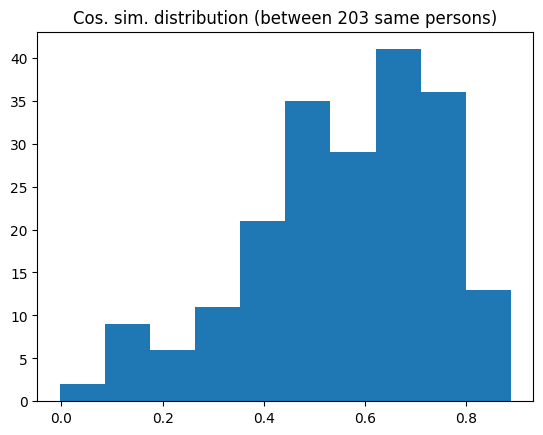

In [ ]:
plt.hist(list(result))
plt.title(f'Cos. sim. distribution (between {len(result)} same persons)')
plt.show()

In [ ]:
br = 200
result = []
j = 0

while j<br:
  train_dict = []
  test_dict = []
  person_1 = torch.randint(249, 499, (1, 1)).item()

  for i, train in enumerate(train_loader_1im):
      if person_1 == train['label'].item():
          train_dict.append((i, train))

  for i, test in enumerate(test_loader_1im):
      person_2 = torch.randint(1, 249, (1, 1)).item()
      if test['label'].item() == person_2:
          test_dict.append((i, test))
  result = plot(train_dict, test_dict, result, dist=True)
  j = len(result)

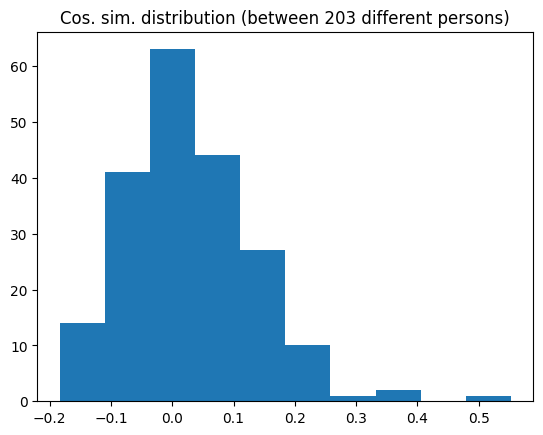

In [ ]:
plt.hist(list(result))
plt.title(f'Cos. sim. distribution (between {len(result)} different persons)')
plt.show()

## Part 2: Identificaton rate metric

When training the model above we used CE loss on val and test set as a measure of performance of our model. But this has a major disadvantage: we can't measure how godd a model would work on unseen faces (which are not present in training, val & test sets)

To address this we can calculate another metric for the model: **identification rate**. This is how it works:

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets.

1. calculate cosine similarities between all the faces corresponding to the same people from query dataset. This means if the person has 3 photos in query part: 01.jpg, 02.jpg, 03.jpg, then calculate 3 cosine similarities between every pair of embeddings corresponding to those photos.
2. calculate cosine similarities between all the faces corresponding to the different people from query dataset.
3. calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. This means calculate similarities between pairs (q, d), where q is the embedding that corresponds to a face from query, d — embedding that corresponds to a face from distractors. You'll get |query|*|distractors| similarities.
4. Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
5. fix **FPR** (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
6. Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our **threshold similarity**.
7. Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.

Datasets (query photos, query labels & distructors photos) download using the code below:

In [ ]:
! curl -L $(yadisk-direct https://disk.yandex.com/d/KN4EEkNKrF_ZXQ) -o celebA_ir.zip
! unzip -qq celebA_ir.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8978k  100 8978k    0     0  2854k      0  0:00:03  0:00:03 --:--:-- 5350k


Implementing the TPR@FPR metric. Calculating it for model and test dataset on FPR=[0.5, 0.2, 0.1, 0.05].


In [ ]:
dir_path = Path('celebA_ir')
query_dir = 'celebA_query'
distractor_dir = 'celebA_distractors'
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors')

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

In [ ]:
transform = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.3, 0.3, 0.3)),
])

model.load_state_dict(torch.load('/content/model_CE.pt'))
model.classify = False
model.eval()
model = model.to(device)

class IR_Dataset(Dataset):
    def __init__(self, images_list, images_dir, transform):
        self.transform = transform
        self.files = images_list
        self.data = [self.load_sample(images_dir / img_name) for img_name in self.files]

    def __len__(self):
        return len(self.data)

    def load_sample(self, filename):
        image = Image.open(filename)
        image.load()
        return image

    def __getitem__(self, idx):
        x = self.data[idx]
        x = self.transform(x)
        return x, self.files[idx]

In [ ]:
def compute_embeddings(model, images_list, images_subdir=query_dir):
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images
          names from images_list
  '''
  img_data = IR_Dataset(images_list, dir_path / images_subdir, transform)
  data_loader = torch.utils.data.DataLoader(img_data, batch_size=batch_size, shuffle=False)

  filenames_per_eval = []
  embs_per_eval = []
  model.eval()
  with torch.no_grad():
      for X_batch, y_batch in data_loader:
          filenames_per_eval.extend(y_batch)
          X_batch = X_batch.to(device)
          outputs = model(X_batch)
          embs_per_eval.extend(outputs.cpu().detach().numpy())
  return embs_per_eval

query_embeddings = compute_embeddings(model, query_img_names, images_subdir=query_dir)
distractors_embeddings = compute_embeddings(model, distractors_img_names, images_subdir=distractor_dir)

def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between positive pairs from query (stage 1)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding
                      to the same people from query list
    '''
    cos_sims = []
    for person_id in query_dict:
        embs = []
        for img_name in query_dict[person_id]:
            ind = query_img_names.index(img_name)
            embs.append(np.array(query_embeddings[ind]))
        cos_sim = cosine_similarity(np.array(embs))
        del embs

        # Excluding self similarities and duplicates
        cos_sims.extend(cos_sim[np.triu_indices_from(cos_sim, k=1)])

    return cos_sims


def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between negative pairs from query (stage 2)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding
                      to different people from query list
    '''
    cos_sims = []
    for person_id_1 in query_dict:
        embs_1 = []
        for img_name_1 in query_dict[person_id_1]:
            ind_1 = query_img_names.index(img_name_1)
            embs_1.append(np.array(query_embeddings[ind_1]))
        for person_id_2 in query_dict:
            # Excluding self similarities and duplicates
            if person_id_2 <= person_id_1:
                continue
            embs_2 = []
            for img_name_2 in query_dict[person_id_2]:
                ind_2 = query_img_names.index(img_name_2)
                embs_2.append(np.array(query_embeddings[ind_2]))
            cos_sim = cosine_similarity(np.array(embs_1), np.array(embs_2))
            del embs_2
            cos_sims.extend([x for xs in cos_sim for x in xs])
        del embs_1
    return cos_sims


def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
      query_embeddings: list of embeddings corresponding to query_img_names
      distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
      list of floats: similarities between pairs of people (q, d), where q is
                      embedding corresponding to photo from query, d —
                      embedding corresponding to photo from distractors
    '''
    cos_sims = cosine_similarity(np.array([data for data in query_embeddings]),
                                 np.array([data for data in distractors_embeddings]))
    return [x for xs in cos_sims for x in xs]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distractors_embeddings)

Implement the final function: identification rate calculation

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=0.1):
  '''
  compute identification rate using precomputer cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output:
    float: threshold for given fpr
    float: TPR at given FPR
  '''
  neg_list = cosine_query_neg + cosine_query_distractors
  neg_list.sort(reverse=True)
  false_pairs_number = len(neg_list)
  n = int(fpr * false_pairs_number)
  thr_similarity = neg_list[n]
  return thr_similarity, len([sim for sim in cosine_query_pos if sim >= thr_similarity]) / len(cosine_query_pos)

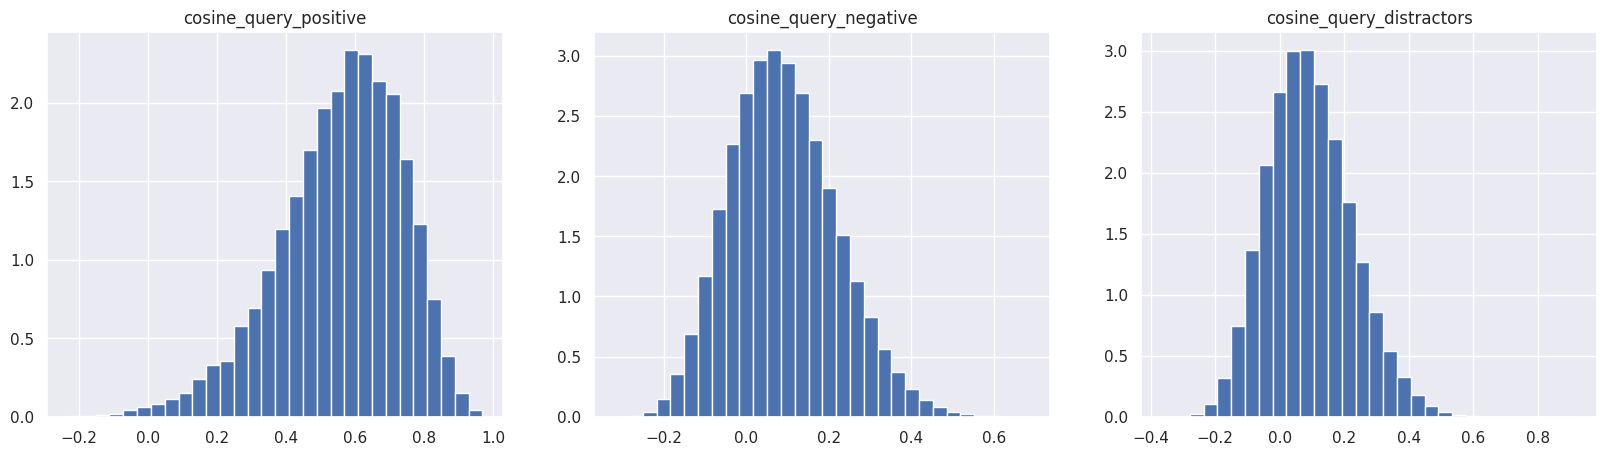

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax[0].hist(cosine_query_pos, bins=30, density=True)
ax[0].set_title('cosine_query_positive')
ax[1].hist(cosine_query_neg, bins=30, density=True)
ax[1].set_title('cosine_query_negative')
ax[2].hist(cosine_query_distractors, bins=30, density=True)
ax[2].set_title('cosine_query_distractors')
plt.plot();

TPR for faces query and distractors dataset and FPR = [0.5, 0.2, 0.1, 0.05]:

In [ ]:
thr_values, tpr_values, fpr_values = [], [], []
for fpr in [0.5, 0.2, 0.1, 0.05]:
    thr, tpr = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr)
    fpr_values.append(fpr)
    thr_values.append(thr)
    tpr_values.append(tpr)
table_data = []
for fpr, thr, tpr in zip(fpr_values, thr_values, tpr_values):
    table_data.append([fpr, thr, tpr])

headers = ['FPR', 'Thr', 'TPR']

table = tabulate(table_data, headers, tablefmt='grid')
print(table)

+-------+-----------+----------+
|   FPR |       Thr |      TPR |
+=======+===========+==========+
|  0.5  | 0.0834126 | 0.987093 |
+-------+-----------+----------+
|  0.2  | 0.200824  | 0.959989 |
+-------+-----------+----------+
|  0.1  | 0.266241  | 0.933904 |
+-------+-----------+----------+
|  0.05 | 0.321516  | 0.89892  |
+-------+-----------+----------+


## Part 3: Other loss functions

Building a network on task 1 we used an ordinary CE loss. But there are many more variants of loss functions that can be used to train neural network. We will discuss two of them, which are the most popular.

### TripletLoss

This is another kind of loss which does not require a model to have last classification layer — it works directly with embeddings. It requires by design to make embeddings of one person be close on embeddings space and embeddings of different people be far away from each other.

This loss has an advantage over CE-like losses: it does not rely on number of classes in dataset. If we have new faces of new people in a dataset, we won't need to completely retrain the network, we could just fine-tune the trained network on new photos.


**How TripletLoss works**:

Here the architecture of neural network will be slightly different than it was when we used CE loss: it won't have the last classification layer. The last layer of NN will output embeddings of the given photo.

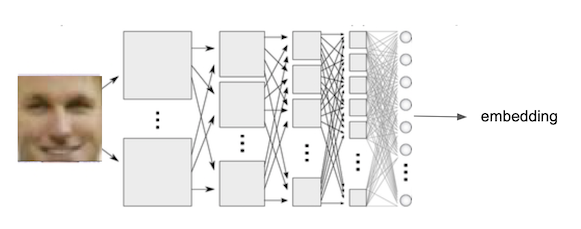

The TripletLoss function works directly with these embeddings. The idea of it is to make embeddings of the same people more close, compact in the embedding space, and the embeddings of the different people be more separate. There's a formula for the loss:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

where
- $e$ is embedding of a photo (output of a model)
- $p$ is a positive embedding for the photo (embedding that we want $e$ be close to)
- $n$ is a negative embedding for the photo (embedding that we want $e$ be far from)
- $d(x, y)$ is a distance measure between embeddings
- margin — a positive margin to further boost the difference between $d(a, p)$ and $d(a, n)$

**All the embeddings $e$, $p$ and $n$ must be normalized before passing them to the loss**.

In our case for the given photo $E$ and it's embedding $e$ positive embedding $p$ must be an embedding of the photo of the same person and embedding $n$ must be an ambedding of the photo of the different person.

This emplementation of TripletLoss for PyTorch can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss).


In [ ]:
import torch.nn.functional as F
import pandas as pd
import random
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
class Triplet_celebADataset(Dataset):
    def __init__(self, dataset_type, transform):
        self.images = get_paths(dataset_type=dataset_type)
        self.dataset_type = dataset_type

        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()

        labels = [x.strip().split() for x in labels]
        labels = {x:int(y) for x, y in labels}

        self.labels = [labels[x.split('/')[-1]] for x in self.images]
        self.transform = transform
        self.df = pd.DataFrame(data={'original': self.images, 'label': self.labels})

        triplet_df = pd.DataFrame(columns=['label', 'positives', 'negatives'])

        for label in range(500):
            negatives = list(self.df[self.df.label != label].original.values)
            positives = list(self.df[self.df.label == label].original.values)
            data = {'label': [label], 'positives': [positives], 'negatives': [negatives]}
            new_row = pd.DataFrame(data)
            triplet_df = pd.concat([triplet_df, new_row], ignore_index=True)
        self.triplet_df = triplet_df

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        anchor = self.images[idx]
        anchor_tensor = self.transform(Image.open(anchor))

        if self.dataset_type in ['train', 'val']:
            all_positives = self.triplet_df[self.triplet_df.label == label].positives.values[0]
            all_negatives = self.triplet_df[self.triplet_df.label == label].negatives.values[0]

            positive = random.choice(all_positives)
            negative = random.choice(all_negatives)

            positive_tensor = self.transform(Image.open(positive))
            negative_tensor = self.transform(Image.open(negative))

            return anchor_tensor, positive_tensor, negative_tensor, label
        else:
            return anchor_tensor, label

In [ ]:
transform = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.3, 0.3, 0.3)),
])

transform_train = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.3, 0.3, 0.3)),
      transforms.RandomHorizontalFlip()
])

train_Tr = Triplet_celebADataset('train', transform_train)
val_Tr = Triplet_celebADataset('val', transform)
test_Tr = Triplet_celebADataset('test', transform)

batch_size = 50
train_TripletLoss_loader = torch.utils.data.DataLoader(train_Tr, batch_size=batch_size, shuffle=True)
val_TripletLoss_loader = torch.utils.data.DataLoader(val_Tr, batch_size=batch_size, shuffle=False)
test_TripletLoss_loader = torch.utils.data.DataLoader(test_Tr, batch_size=batch_size, shuffle=False)

dataset_sizes = {
    'train': len(train_data),
    'val': len(val_data)
}

In [ ]:
def train_model(model,criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = model.state_dict()
    w_loss = 10**2

    losses = {'train': [], "val": []}
    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
                loader = train_TripletLoss_loader
            else:
                model.eval()
                loader = val_TripletLoss_loader

            running_loss = 0.0
            running_corrects = 0

            for anchor, positive, negative, labels in tqdm(loader, leave=False, desc=f"{phase} iter:"):

              if phase=="train":
                    anchor_emb = model(anchor.to(device))
                    positive_emb = model(positive.to(device))
                    negative_emb = model(negative.to(device))

                    optimizer.zero_grad()
                    loss = criterion(anchor_emb, positive_emb, negative_emb)
                    loss.backward()
                    optimizer.step()

              if phase=='val':
                  with torch.no_grad():
                    anchor_emb = model(anchor.to(device))
                    positive_emb = model(positive.to(device))
                    negative_emb = model(negative.to(device))
                    loss = criterion(anchor_emb, positive_emb, negative_emb)


              running_loss += loss.item()
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            losses[phase].append(epoch_loss)

            pbar.set_description('{} Loss: {:.6f}'.format(
                                    phase, epoch_loss))

            # save best model
            if phase == 'val' and epoch_loss < w_loss:
                w_loss = epoch_loss
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model
    model.load_state_dict(best_model_wts)
    return model, losses

In [ ]:
model = InceptionResnetV1(pretrained='vggface2', classify=False)

for param in model.parameters():
    param.requires_grad = False

model.last_linear = nn.Sequential(
    nn.Linear(in_features=1792, out_features=2000, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(2000, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
    nn.Linear(in_features=2000, out_features=1500, bias=False),
    nn.ReLU(),
)
model.last_bn = nn.BatchNorm1d(1500, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
model.logits = nn.Identity()

if use_gpu:
  model = model.cuda()

MARGIN = 0.5
loss_fn = nn.TripletMarginWithDistanceLoss(distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y), margin=MARGIN)
optimizer_ft = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.5)

In [ ]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=10)
torch.save(model.state_dict(), 'model_TR.pt')

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

Training complete in 22m 19s


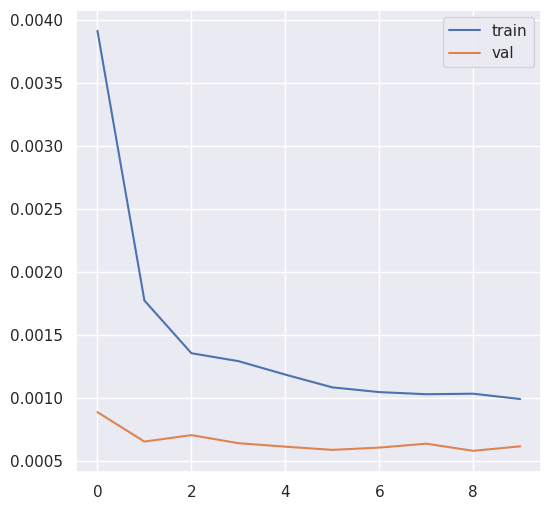

In [ ]:
sns.set(font_scale=1.0)

plt.figure(figsize=(6, 6))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

**Evaluate**:

In [ ]:
def evaluate(model, test_loader=test_TripletLoss_loader):
  model.eval()
  with torch.no_grad():
    list_emb_num=[]
    correct = 0
    for label in range(500):
            pos_list = list(train_Tr.df[train_Tr.df.label == label].original.values)
            label_emb = model((torch.stack([train_Tr.transform(Image.open(i)) for i in pos_list])).to(device))
            label_mean_emb = np.expand_dims(np.mean((label_emb.cpu().detach().numpy()), 0), 0)
            if label == 0:
              list_embeddings = label_mean_emb
              continue
            list_embeddings = np.concatenate((list_embeddings, label_mean_emb), 0)

    for anchor, label in test_loader:
      anchor_emb = model(anchor.to(device)).cpu()
      cos = cosine_similarity(anchor_emb.detach().numpy(), list_embeddings)
      result = torch.argmax(torch.Tensor(cos), 1)
      correct += torch.sum(result == label).item()
  test_acc = correct / len(test_Tr)
  return test_acc

In [ ]:
print(f'test_accuracy: {evaluate(model)}')

test_accuracy: 0.8571428571428571


### ArcFace Loss (Additive Angular Margin Loss)

This loss is somewhat "SOTA" for face recognition systems (somewhat — because actually different variants of losses and their combinations may be the best for different network architectures). This loss inherits idea from CE loss but further develops it to achieve better embeddings distribution on a sphere. It introduces some geodesic constraints to enhance intra-class compactness and inter-class discrepancy.



**How ArcFace loss works**:

This loss is a variation of a standard SoftMax CE loss, which enforces embeddings of different classes (people) be further away: have a more sparse representation of embeddings in embedding space, enforce more evident gap between the nearest classes.

The standard SoftMax CE loss for classification task is presented as follows:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

where:
- $x_i \in \mathbb{R^d}$ denotes the deep feature of the $i$-th sample, belonging to the $y_i$-th class;
- $W_j \in \mathbb{R^d}$ denotes the j-th column of the weight;
- $W \in \mathbb{R^d}$ and $b_j \in \mathbb{R^d}$ is the bias term;
- $N$ — batch size;
- $n$ — class number.

It appears, that, though this loss works well, it does not explicitly optimise the feature embedding to enforce higher similarity for intra- class samples and diversity for inter-class samples, which results in a performance gap for deep face recognition under large intra-class appearance variations.

Let's do some work on this loss formula:
- fix the bias $b_j=0$;
- normalize weight ||$W_j$|| = 1;
- normalize embedding ||$x_i$|| = 1 and re-scale it to s (s is a hyperparameter)

The normalisation step on embeddings and weights makes the predictions only depend on the angle between the embedding and the weight. The learned embeddings fare thus distributed on a hypersphere with a radius of s.

So we get the following loss function now:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Final step: let's add an additive angular margin penalty $m$ between $x_i$ and $W_{y_i}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

SO this is an ArcFace loss. It has 2 hyperparameters: s and m.

In [ ]:
!git clone https://github.com/ronghuaiyang/arcface-pytorch arcface
py_file_location = "/content/arcface/models"
sys.path.append(os.path.abspath(py_file_location))

from metrics import AddMarginProduct as ArcFace

Cloning into 'arcface'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 67 (delta 23), reused 20 (delta 20), pack-reused 28
Unpacking objects: 100% (67/67), 118.88 KiB | 4.10 MiB/s, done.


In [ ]:
class ArcFace_celebADataset(Dataset):
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)
        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

        self.transform = transform
        self.aug = aug

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_name)

        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            sample = {
                'image': image,
                'label': label,
            }

        sample['image'] = self.transform(sample['image'])

        return sample

In [ ]:
transform = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.3, 0.3, 0.3)),
])

transform_train = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.3, 0.3, 0.3)),
      transforms.RandomHorizontalFlip()
])

train_AF = ArcFace_celebADataset('train', transform_train)
val_AF = ArcFace_celebADataset('val', transform)
test_AF = ArcFace_celebADataset('test', transform)

batch_size = 50
train_ArcFace_loader = torch.utils.data.DataLoader(train_AF, batch_size=batch_size, shuffle=True)
val_ArcFace_loader = torch.utils.data.DataLoader(val_AF, batch_size=batch_size, shuffle=False)
test_ArcFace_loader = torch.utils.data.DataLoader(test_AF, batch_size=batch_size, shuffle=False)

dataset_sizes = {
    'train': len(train_AF),
    'val': len(val_AF)
}

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, arcface_loss, arcface_optim):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    w_loss = 10**5


    losses = {'train': [], "val": []}
    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
                loader = train_ArcFace_loader
            else:
                model.eval()
                loader = val_ArcFace_loader

            running_loss = 0.0
            running_corrects = 0

            for data in tqdm(loader, leave=False, desc=f"{phase} iter:"):
                inputs, labels = data['image'], data['label']

                if use_gpu:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                else:
                    inputs, labels = inputs, labels

                if phase=="train":
                    optimizer.zero_grad()
                    arcface_optim.zero_grad()

                # forward pass
                if phase == "val":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                #preds = torch.argmax(outputs, -1)
                loss_arc = arcface_loss(outputs, labels)
                loss = criterion(loss_arc, labels)

                # backward pass + optimizer
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    arcface_optim.step()

                # stats
                running_loss += loss.item()

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            losses[phase].append(epoch_loss)

            pbar.set_description('{} Loss: {:.6f}'.format(
                                    phase, epoch_loss))

            # save best model
            if phase == 'val' and epoch_loss < w_loss:
                w_loss = epoch_loss
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model
    model.load_state_dict(best_model_wts)
    return model, losses

In [ ]:
model = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = 500)

for param in model.parameters():
    param.requires_grad = False

model.last_linear = nn.Sequential(
    nn.Linear(in_features=1792, out_features=2000, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(2000, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
    nn.Linear(in_features=2000, out_features=1500, bias=False),
    nn.ReLU(),
)
model.last_bn = nn.BatchNorm1d(1500, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
model.logits = nn.Identity()

if use_gpu:
  model = model.cuda()

loss_fn = nn.CrossEntropyLoss()
arcface_loss = ArcFace(in_features=1500, out_features=500, s=30.0, m=0.50).to(device)
arcface_optim = torch.optim.AdamW(arcface_loss.parameters(), lr=1e-3)
optimizer_ft = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.5)

In [ ]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=10, arcface_loss=arcface_loss, arcface_optim=arcface_optim)
torch.save(model.state_dict(), 'model_AF.pt')

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

train iter::   0%|          | 0/171 [00:00<?, ?it/s]

val iter::   0%|          | 0/38 [00:00<?, ?it/s]

Training complete in 6m 58s


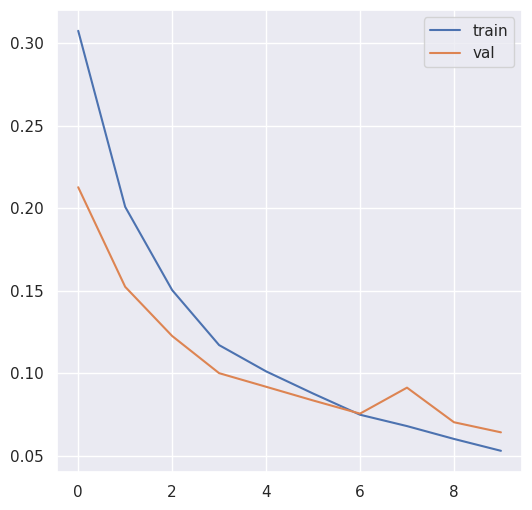

In [ ]:
sns.set(font_scale=1.0)

plt.figure(figsize=(6, 6))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

**Evaluate**:

In [ ]:
def evaluate(model, loader=train_ArcFace_loader):
  model.eval()
  with torch.no_grad():
    labels = []
    emb = []
    for imgs in loader:
      image_emb, label = model(imgs['image'].to(device)), imgs['label']
      emb.append(image_emb)
      labels.append(label)
    labels = [k.item() for i in labels for k in i]
    emb = [k for i in emb for k in i]
    embedding = torch.stack((emb))
    correct_labels = 0
    for batch in test_AF:
        image, true_label = batch['image'].to(device), batch['label']
        img_emb = model(image.unsqueeze(0))
        similarities = matrix_similarity(img_emb, embedding)
        pred_label = labels[similarities.argmax()]
        correct_labels += (np.array(pred_label) == np.array(true_label)).sum()

    acc = correct_labels / len(test_AF)
  return acc

In [ ]:
print(f'test_accuracy: {evaluate(model)}')

test_accuracy: 0.9446192573945877


## **Summary of the models:**
\begin{array}{lccccc}
{№} & loss\_fun    & test\_accuracy, \% & time/epoch, sec & lr   & other          \\
1                    & CrossEntropy & 93.9               & 42              & 1e-4 & None           \\
2                    & TripletLoss  & 85.7               & 132             & 1e-4 & MARGIN = 0.5   \\
3                    & ArcFaceLoss  & 94.5               & 41              & 1e-3 & s=30.0, m=0.50
\end{array}

## Part 4: Testing on full CelebA dataset and visualizing embeddings

Checking ArcFaceLoss on a full dataset with 10k classes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/CelebA/Img/img_align_celeba.zip

In [ ]:
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

In [ ]:
anno = '/content/drive/MyDrive/identity_CelebA.txt'
img_path = Path('/content/img_align_celeba')
f = open(anno, 'r')
lines = f.readlines()
f.close()

dic = dict()
labels, images = [], []
for i in range(len(lines)):
    img_name = lines[i].split()[0]
    label = int(lines[i].split()[1])
    labels.append(label)
    images.append(img_name)
    if label not in dic:
        dic[label] = []
    dic[label].append(img_name)
labels_trsh = [k for k in dic if len(dic[k]) < 4]
images = [images[i] for i in range(len(labels)) if labels[i] not in labels_trsh]
labels = [labels[i] for i in range(len(labels)) if labels[i] not in labels_trsh]
labels_to_idx = {v: k for k, v in (dict(enumerate(list(set(labels))))).items()}
print('Classes:', len(set(labels)))

Classes: 9564


In [ ]:
img_train, img_test, label_train, label_test = train_test_split(images, list(map(lambda x: labels_to_idx[x], labels)),
                                                                test_size=0.2, random_state=42, shuffle=True, stratify=labels)

In [ ]:
class ArcFace_FULL_celebADataset(Dataset):
    def __init__(self, files, labels, transform):
        self.transform = transform
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def load_sample(self, name_img):
        image = Image.open(img_path / name_img)
        image.load()
        return image

    def __getitem__(self, idx):
        x = self.load_sample(self.files[idx])
        x = self.transform(x)
        return x, self.labels[idx]

transform = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.3, 0.3, 0.3)),
])

train_full = ArcFace_FULL_celebADataset(img_train, label_train, transform)
test_full = ArcFace_FULL_celebADataset(img_test, label_test, transform)

batch_size = 100
train_loader = torch.utils.data.DataLoader(train_full, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_full, batch_size=batch_size, shuffle=False)

dataset_sizes = {
    'train': len(train_full),
    'val': len(test_full)
}

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/model_AF.pt'))
model.logits = nn.Identity()
model = model.to(device)

In [ ]:
def evaluate(model, train_loader=train_loader, test_loader=test_loader):
    model.eval()
    with torch.no_grad():
        # Make embenddings
        train_embs = [[] for i in range(len(set(labels)))]
        for sample_batch, label_batch in tqdm(train_loader, desc='Embeddings'):
            sample_batch = sample_batch.to(device)
            sample_out = model(sample_batch)
            outputs = sample_out.cpu().detach().numpy()

            for i in range(outputs.shape[0]):
                train_embs[label_batch[i]].append(outputs[i])
        # Mean embeddings for classes
        for i in range(len(train_embs)):
            train_embs[i] = np.mean(train_embs[i], axis=0)
        preds_per_epoch, targets_per_epoch = [], []
        for sample_batch, label_batch in tqdm(test_loader, desc='Inference'):
            targets_per_epoch.extend(label_batch)
            sample_batch = sample_batch.to(device)
            sample_out = model(sample_batch)
            outputs = sample_out.cpu().detach().numpy()
            outputs_similarities = cosine_similarity(outputs, train_embs)

            preds = np.argmax(outputs_similarities, axis=1)
            preds_per_epoch.extend(preds)
    return accuracy_score(targets_per_epoch, preds_per_epoch)
acc = evaluate(model)

Embeddings:   0%|          | 0/1610 [00:00<?, ?it/s]

Inference:   0%|          | 0/403 [00:00<?, ?it/s]

In [ ]:
print(f'Accuracy on {len(set(labels))} classes: {acc}')

Accuracy on 9564 classes: 0.7853361501180565


Visualization of embeddings of 50 classes:

In [ ]:
persons = random.sample(range(0, len(set(labels))), 50)
persons_data = [{'data': train_full[i][0], 'id': label_train[i]} for i in range(len(label_train)) if label_train[i] in persons]
model.eval()
for i in range(len(persons_data)):
    person_tensor = persons_data[i]['data'].clone().detach().unsqueeze(0).to(device)
    with torch.no_grad():
        persons_data[i]['emb'] = model(person_tensor).squeeze().cpu().detach().numpy()
embs = [data['emb'] for data in persons_data]
embs = np.array(embs)

tsne = TSNE(n_components=2, init='random', learning_rate=100)
embs_transformed = tsne.fit_transform(embs)
for i in range(len(persons_data)):
    persons_data[i]['tsne'] = embs_transformed[i]

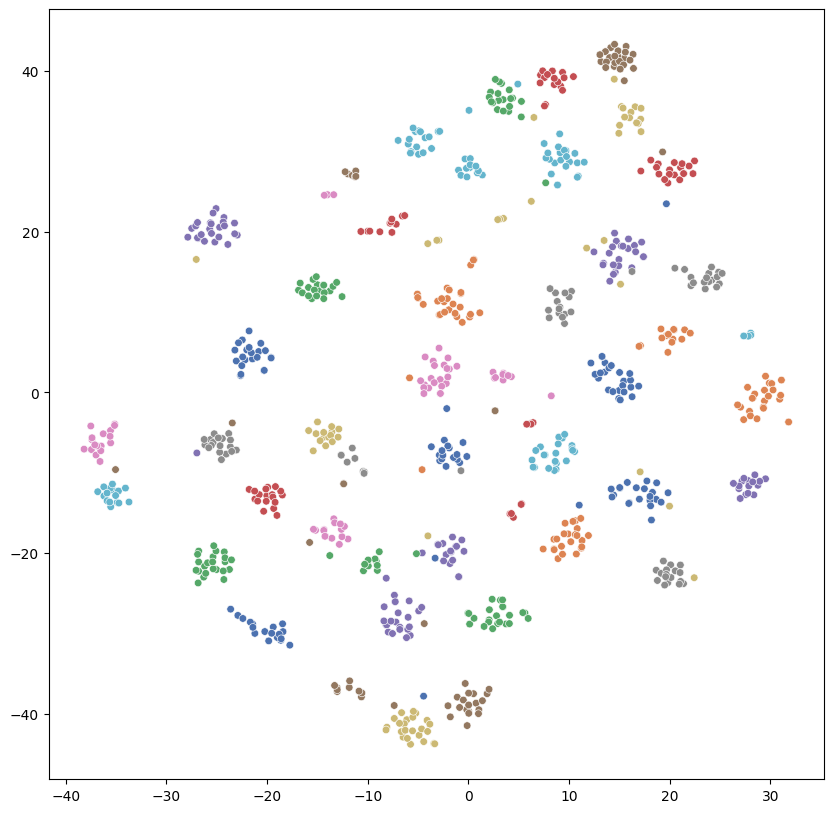

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=[data['tsne'][0] for data in persons_data], y=[data['tsne'][1] for data in persons_data],
                hue=[data['id'] for data in persons_data], palette='deep', s=30);
plt.legend().set_visible(False)